In [1]:
import wandb
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
import numpy as np
from collections import defaultdict
from cycler import cycler

In [2]:
experiment_name = "v3_r50u20"
# experiment_name = "v3_r100u100"
# experiment_name = "v3_r300u100"
# experiment_name = "v3_r300u100_flip"

In [3]:
api = wandb.Api()

# 1. Pull wandb runs from a specific organization and project
runs = api.runs('sita/source-reliability')

# 2. Filter the runs
filtered_runs = [run for run in runs if run.config.get('experiment_name') == experiment_name and run.state not in ["crashed", "failed"]]

# 3. Group the runs by run.config.data_path
runs_by_path = defaultdict(list)
for run in filtered_runs:
    data_path = run.config.get('data_path')
    if data_path:
        runs_by_path[data_path].append(run)

print(f'Found {len(runs_by_path)} groups of runs:')
for data_path, runs in runs_by_path.items():
    print(f'{data_path}: {len(runs)} runs')



Found 4 groups of runs:
v3_r50u20_news_rg1re1_05: 20 runs
v3_r50u20_news_rg1re1_075: 20 runs
v3_r50u20_news_rg1re1_09: 20 runs
v3_r50u20_news_rg1re1: 20 runs


In [4]:
# Old color palette
# colors = plt.cm.cool(np.linspace(0,1,6))[::-1]  # Generate 6 colors from cool colormap in reversed order
# colors = colors[:4][::-1]
# plt.rcParams["axes.prop_cycle"] = cycler(color=colors)

# seaborn rocket
rocket_palette = ['#ffa600', '#ff6e54', '#dd5182', '#955196']
plt.rcParams["axes.prop_cycle"] = cycler(color=rocket_palette)

In [5]:
def get_reliability_from_datapath(data_path: str) -> int:
    sep = "_0"
    if sep not in data_path:
        reliability = 100
    else:
        reliability = data_path.split(sep)[1]
        reliability = reliability.ljust(2, '0')
    return int(reliability)

In [15]:
# 4. Make data for the plot
plot_data = []
for data_path, runs in runs_by_path.items():

    # Collect epoch and accuracy data across runs for the same data path
    accuracies_by_epoch = defaultdict(list)
    for run in runs:
        num_epochs = run.config.get('num_epochs')
        # 1. look for keys `mean/winrate_reliable` and `eval_mean/winrate_reliable` in the scan history
        # 2. treat them as the same
        # 3. assume only one of the keys is present per run
        winrate_keys = ['mean/winrate_reliable', 'eval_mean/winrate_reliable']
        winrate_key = None
        for key in winrate_keys:
            if key in run.summary:
                winrate_key = key
                break

        history = run.scan_history(keys=[winrate_key])
        for i, row in enumerate(history):
            epoch_num = i+1 # assume logged once per epoch
            accuracies_by_epoch[epoch_num].append(row[key])

        assert len(accuracies_by_epoch) == num_epochs, f"num_epochs: {num_epochs}, len(accuracies_by_epoch): {len(accuracies_by_epoch)}"

    # Convert to numpy arrays for easier manipulation
    epochs = np.array(list(accuracies_by_epoch.keys()))
    accuracies = np.array(list(accuracies_by_epoch.values()))

    # Calculate mean and standard deviation
    mean_accuracy = np.mean(accuracies, axis=1)
    std_accuracy = np.std(accuracies, axis=1)

    # Plot mean accuracy and standard deviation
    plot_data.append((data_path, epochs, mean_accuracy, std_accuracy))

In [16]:
# 4. Sort plot data by datapath (reverse order)
plot_data.sort(key=lambda x: get_reliability_from_datapath(x[0]), reverse=True)

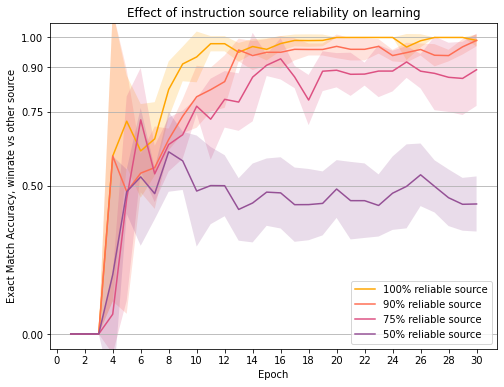

In [18]:
for data_path, epochs, mean_accuracy, std_accuracy in plot_data:
    reliability = get_reliability_from_datapath(data_path)
    label = f"{reliability}% reliable source"

    plt.plot(epochs, mean_accuracy, label=label)
    plt.fill_between(epochs, mean_accuracy-std_accuracy, mean_accuracy+std_accuracy, alpha=0.2)


# Show the plot
plt.grid(axis='y')
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=15+1))

plt.title('Effect of instruction source reliability on learning')
plt.xlabel('Epoch')
plt.ylabel('Exact Match Accuracy, winrate vs other source')
plt.legend(loc='lower right')

plt.yticks([0.0, 0.5, 0.75, 0.9, 1.0])
plt.ylim(-0.05, 1.05)
plt.savefig(f'reliability_{experiment_name}.png', dpi=300)
plt.savefig(f'reliability_{experiment_name}.pdf', dpi=300)

# make it bigger
plt.gcf().set_size_inches(8, 6)

In [ ]:
import pandas as pd

# Initialize a DataFrame to store the final results
results_df = pd.DataFrame(columns=['Group', 'Accuracy (max of avg over 5 runs)', 'Standard Deviation'])


for group in plot_data:
    epochs, mean_accuracy, std_accuracy, label = group
    max_mean_accuracy = max(mean_accuracy)
    std_dev = std_accuracy[-1]

    results_df = results_df.append({
        'Group': label,
        'Accuracy (max of avg over 5 runs)': max_mean_accuracy,
        # limit std to 3 decimal places
        'Standard Deviation': f'{std_dev:.3f}',
    }, ignore_index=True)

# Display the DataFrame
results_df


/var/folders/fp/2b103mk15m173df0t9_rd58c0000gn/T/ipykernel_71089/2626466098.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/fp/2b103mk15m173df0t9_rd58c0000gn/T/ipykernel_71089/2626466098.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/fp/2b103mk15m173df0t9_rd58c0000gn/T/ipykernel_71089/2626466098.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/fp/2b103mk15m173df0t9_rd58c0000gn/T/ipykernel_71089/2626466098.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.appen

,Group,Accuracy (max of avg over 5 runs),Standard Deviation
0,"[0.0, 0.0, 0.0, 0.48989794855663565, 0.1540062...",30,0.990
1,"[0.0, 0.0, 0.0, 0.4898979485566357, 0.41182520...",30,0.990
2,"[0.0, 0.0, 0.0, 0.13333333333333333, 0.3441773...",30,0.891
3,"[0.0, 0.0, 0.0, 0.4000000000000001, 0.07483314...",30,0.438


In [ ]:
# Convert the DataFrame to markdown
markdown_df = results_df.copy()
markdown_df['Accuracy (avg over 5 runs)'] = markdown_df.apply(lambda row: f"{row['Accuracy (avg over 5 runs)']} (STD: {row['Standard Deviation']})", axis=1)
markdown_df = markdown_df.drop(columns='Standard Deviation')

# Print the DataFrame in markdown format
print(markdown_df.to_markdown(index=False))
print(markdown_df.to_latex(index=False))



KeyError: 'Accuracy (avg over 5 runs)'

| Group                    | Final Accuracy (avg over 5 runs)      |
|:-------------------------|:--------------------------------|
| 50% reliable  | 0.488 (STD: 0.039) |
| 75% reliable  | 0.778 (STD: 0.019)              |
| 90% reliable  | 0.919 (STD: 0.030) |
| 100% reliable | 0.984 (STD: 0.014)              |